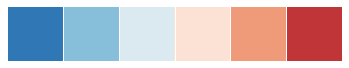

In [45]:
import sys
from itertools import chain

#!pip install -r requirements.txt

# common tools
import pickle
import pandas as pd
import collections
from collections import Counter
from tqdm import tnrange, tqdm_notebook

# from io import StringIO
import numpy as np

# nlp tools
from string import punctuation
import pymystem3
import pymorphy2
import nltk
import gensim
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# own libs
# !pip install dill
import preprocessing_methods as pm

# plottin'
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# Setting figure size in inches
rcParams['figure.figsize'] = 16, 7
pal = sns.palplot(sns.color_palette("RdBu_r", 6))

In [2]:
train_path = 'X_train.csv'
df = pd.read_csv(train_path)# , delimiter=',', error_bad_lines=False, header=None)
df.head(2)

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN


In [3]:
comment = df['comment'].dropna()
commentPositive = df['commentPositive'].dropna()
commentNegative = df['commentNegative'].dropna()

In [4]:
dataset = (comment, commentPositive, commentNegative)

In [5]:
pp = pm.Preprocessing()

In [6]:
def get_stats(a, b, c):
    # Считаем количество символов
    count_a = len(list(chain.from_iterable(a)))
    count_b = len(list(chain.from_iterable(b)))
    count_c = len(list(chain.from_iterable(c)))
    print('Symbols:', count_a, count_b, count_c)

In [7]:
def apply_to_dataset(dataset, func):
    pros = dataset[0].apply(func)
    cons = dataset[1].apply(func)
    otziv = dataset[2].apply(func)
    get_stats(pros, cons, otziv)
    return (pros, cons, otziv)

In [8]:
normalized = apply_to_dataset(dataset, pp.normalize)
padded = apply_to_dataset(normalized, pp.pad_punctuation)
tokenized = apply_to_dataset(padded, nltk.word_tokenize) # counting tokens now
no_punct = apply_to_dataset(tokenized, pp.remove_punct)
no_stopwords = apply_to_dataset(no_punct, pp.remove_stopwords)

Symbols: 4691513 323849 38231
Symbols: 4907125 336671 39589
Symbols: 869355 58728 6966
Symbols: 699364 48205 5837
Symbols: 506102 34500 4637


In [34]:
# Most frequent tokens over all columns
# Most frequent tokens over all columns
def get_most_frequent_df(dataset):
    most_common_tokens = Counter(chain.from_iterable(list(chain.from_iterable(dataset)))).most_common()
    df = pd.DataFrame(  {'token': [each[0] for each in most_common_tokens],
                               'occurance':  [each[1] for each in most_common_tokens],
                              }).reset_index()
    df.columns = ['rank', 'occurance', 'token']
    return df

freq_df_1 = get_most_frequent_df(no_stopwords)
freq_df_1.head()

,rank,occurance,token
0,0,21912,не
1,1,7658,очень
2,2,2509,нет
3,3,2391,просто
4,4,2198,работает


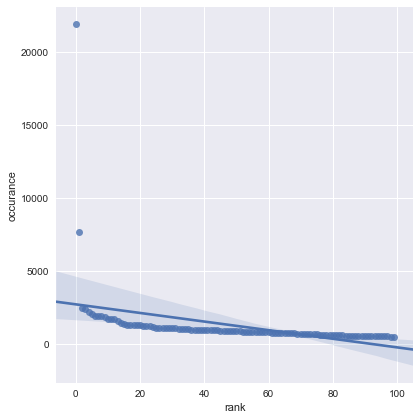

In [10]:
# Index = frequency rank
ax = sns.lmplot(x='rank', y='occurance', data=freq_df_1.head(100), size=6)

In [11]:
vocab = list(freq_df_1['token'].values)
print('vocab len: ', len(vocab))
cyrillic_vocab = [each for each in vocab if pm.is_cyrillic(each)]
print('cyrillic left only: ', len(cyrillic_vocab))
# cut_vocab = list(token_occ_df[token_occ_df['occurance']>5]['token'].values)
# print(len(cut_vocab))

vocab len:  65534
cyrillic left only:  52225


In [12]:
lemma_dict = {}
for each in tnrange(len(cyrillic_vocab), desc='constructing dict'):
    token = cyrillic_vocab[each]
    lemma_dict.update({token: pp.get_pymorphy_lemma(token)})

In [13]:
def replace_lemmas(tokenlist):
    result = []
    for token in tokenlist:
        if token in lemma_dict.keys():
            result.append(lemma_dict[token])
        else:
            result.append(token)
    return result

In [16]:
lemmatized = apply_to_dataset(dataset=no_stopwords, func=replace_lemmas)
freq_df_2 = get_most_frequent_df(lemmatized)

Symbols: 506102 34500 4637


In [17]:
def cut_by_frequcncy(tokenlist):
    freq_vocab = list(freq_df_2[freq_df_2['occurance']>5]['token'].values)
    return [t for t in tokenlist if t in freq_vocab]
cu_by_freq_dataset = apply_to_dataset(lemmatized, cut_by_frequcncy)  

Symbols: 465383 31892 4351


In [18]:
get_most_frequent_df(cu_by_freq_dataset).head(10)

,index,occurance,token
0,0,21912,не
1,1,7658,очень
2,2,4751,купить
3,3,4228,хороший
4,4,4157,год
5,5,3082,работать
6,6,2597,пользоваться
7,7,2509,нет
8,8,2447,отличный
9,9,2391,просто


# Token category filtering

In [19]:
full_punctuation = punctuation+'«»'
full_punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»'

In [20]:
# Flat list of all tokens in all texts
def series_to_chain(series):
    """Chained tokens in Series"""
    return series

In [21]:
def separate_by_category(dataset):
    """ 
    Separates tokens by types of chars in it (punctuation, numbers, ...)
    Takes tokenized texts as input 
    Returns dict of {category:[tokenlist]}
    """
    # all_columns = list(chain(*dataset))
    # print(len(all_columns))
    tokenlists = list(chain(*dataset)) # list(chain.from_iterable(all_columns))
    tokens = list(chain(*tokenlists))
    print(len(tokens))
    
    result = {'num_punct': [],
               'alpha_num': [],
               'alpha_punct': [],
               'punct_tokens': [],
               'numeric_tokens': [],
               'alpha_tokens': [],
               'alpha_num_punct': []}

    for token in tokens:
        # Add flag by symbol category
        punct = [1 for symbol in token if (symbol in full_punctuation)]
        numerics = [1 for symbol in token if (symbol.isnumeric())]
        alpha = [1 for symbol in token if (symbol.isalpha())]

        # If token contains all types
        if (punct and numerics) and alpha:
            result['alpha_num_punct'].append(token)

        # Double
        elif numerics and punct:
            result['num_punct'].append(token)

        elif numerics and alpha:
            result['alpha_num'].append(token)

        elif alpha and punct:
            result['alpha_punct'].append(token)

        # Simple
        elif punct:
            result['punct_tokens'].append(token)

        elif numerics:
            result['numeric_tokens'].append(token)

        elif alpha:
            result['alpha_tokens'].append(token)
            
    return pd.DataFrame.from_dict(result, orient='index').transpose()

In [22]:
separated_df = separate_by_category(cu_by_freq_dataset)
separated_df.head()

501626


,num_punct,alpha_num,alpha_punct,punct_tokens,numeric_tokens,alpha_tokens,alpha_num_punct
0,3-4,мп3,еле-еле,None,2,год,2-х
1,8-10,мп3,какой-то,None,5,работать,4-х
2,5.1,ps3,т.е,None,2,устать,4-х
3,1.,3d,куда-то,None,50,лампочка,3-х
4,2.,xbox360,всё-таки,None,70,гореть,sc-6570


In [24]:
def most_common_in_category(df):
    # 
    result = dict()
    for col in df.columns:
        try:
            col_most_freq = df[col].value_counts().reset_index()
            tokens = col_most_freq['index']
            freqs = col_most_freq[col]
            result[col] = [(t,f) for t,f in zip(tokens, freqs)]
        except:
            result[col] = [None]
    return pd.DataFrame.from_dict(result, orient='index').transpose()

most_common_in_category(separated_df)

,num_punct,alpha_num,alpha_punct,punct_tokens,numeric_tokens,alpha_tokens,alpha_num_punct
0,"(2., 238)","(ps3, 102)","(т.к, 530)",None,"(2, 1910)","(не, 21912)","(2-х, 86)"
1,"(1., 224)","(mp3, 48)","(из-за, 440)",None,"(5, 1441)","(очень, 7658)","(3-х, 54)"
2,"(3., 176)","(3d, 42)","(что-то, 311)",None,"(3, 1260)","(купить, 4751)","(2-й, 30)"
3,"(4., 133)","(2х, 41)","(м-видео, 198)",None,"(1, 960)","(хороший, 4228)","(4-х, 29)"
4,"(5., 116)","(3g, 31)","(т.е, 192)",None,"(4, 843)","(год, 4157)","(3-й, 23)"
5,"(2-3, 112)","(м2, 23)","(м.видео, 163)",None,"(10, 464)","(работать, 3082)","(2-ой, 22)"
6,"(3-4, 82)","(3х, 21)","(т.д, 121)",None,"(6, 341)","(пользоваться, 2597)","(5-ти, 11)"
7,"(1-2, 58)","(win7, 20)","(цена-качество, 120)",None,"(7, 325)","(нет, 2509)","(1-й, 10)"
8,"(1.5, 48)","(gta4, 20)","(p.s, 113)",None,"(8, 269)","(отличный, 2447)","(1-го, 8)"
9,"(4-5, 37)","(ddr3, 20)","(как-то, 102)",None,"(100, 255)","(просто, 2391)","(4-ку, 7)"


In [28]:
# Leave only alpha
alpha_tokens = set(separated_df['alpha_tokens'])

In [66]:
def cut_by_vocab(tokenlist):
    return [t for t in tokenlist if t in alpha_tokens]
only_alpha_dataset = apply_to_dataset(cu_by_freq_dataset, cut_by_vocab)

Symbols: 447200 30872 4234


In [67]:
freq_df_alpha = get_most_frequent_df(only_alpha_dataset)
freq_df_alpha.head()

,rank,occurance,token
0,0,21912,не
1,1,7658,очень
2,2,4751,купить
3,3,4228,хороший
4,4,4157,год


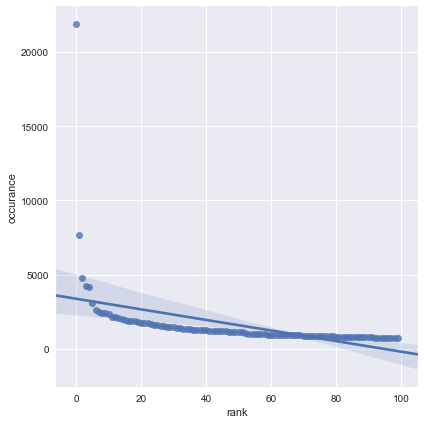

In [68]:
sns.lmplot(x='rank', y='occurance', data=freq_df_alpha.head(100), size=6)

# Check token lenght 

In [69]:
len_tuples = [(each,len(each)) for each in alpha_tokens]
lets_see = sorted(len_tuples, reverse=True, key=lambda x: x[1])
lets_see[:10]

[('многофункциональность', 21),
 ('проконсультироваться', 20),
 ('многофункциональный', 19),
 ('производительность', 18),
 ('экспериментировать', 18),
 ('воздухоувлажнитель', 18),
 ('последовательность', 18),
 ('стеклокерамический', 18),
 ('самозатачивающийся', 18),
 ('транспортировочный', 18)]

# POS-tags

In [70]:
def get_tokenchain(dataset):
    tokenlists = list(chain(*dataset)) # list(chain.from_iterable(all_columns))
    tokens = list(chain(*tokenlists))
    return tokens

In [71]:
alltokens_alpha = get_tokenchain(only_alpha_dataset)

In [72]:
tags_nltk_tuple = nltk.pos_tag(alltokens_alpha, lang='rus')
tags_nltk_tuple[:10]

[('год', 'S'),
 ('работать', 'V'),
 ('устать', 'V'),
 ('лампочка', 'S'),
 ('гореть', 'V'),
 ('большой', 'A=m'),
 ('ничто', 'S-PRO'),
 ('через', 'PR'),
 ('месяц', 'S'),
 ('после', 'PR')]

In [74]:
tags = set([each[1] for each in tags_nltk_tuple])
len(tags)

51

In [75]:
def get_tokens_by_tag(tag):
    # Set of tokens by input tag
    tagged_tokens = [each[0] for each in tags_nltk_tuple if each[1]==tag]
    return tagged_tokens

# {tag: [tokens]}
tag_dict = collections.OrderedDict(zip(tags, [get_tokens_by_tag(tag) for tag in tags]))

In [76]:
tag_frame = pd.DataFrame.from_dict(tag_dict, orient='index').transpose()

In [77]:
pd.options.display.max_columns = 51
most_common_in_df(tag_frame)

,A,NUM=ins,NONLEX,A=m,CONJ,A-PRO=pl,A-PRO,ANUM=m,ADV-PRO=comp,A=n,A-PRO=m,V,ADV,NUM=m,A=plen,A-PRO=sg,PART,NUM=nom,A=comp,ADV-PRO=distort,S-PRO=m,A-PRO=f,NUM=f,PRAEDIC-PRO,INTJ=distort,PRAEDIC=comp,ADV-PRO,ANUM=f,S-PRO=f,PRAEDIC,NUM,INTJ,A=sg,ANUM=n,PARENTH,A=f,S,A=brev,NUM=acc,ADV=comp,PR,ANUM=sg,A=pl,NONLEX=abbr,NUM=gen,NUM=comp,A-PRO=n,ADV=comp2,S-PRO,NUM=n,A=comp2
0,"(рад, 106)","(драйвер, 1)","(usb, 186)","(хороший, 4187)","(ни, 773)","(многие, 88)","(таков, 12)","(один, 388)","(более, 1)","(целое, 181)","(самый, 1109)","(купить, 4751)","(очень, 7658)","(два, 1579)","(очевидно, 1)","(всякий, 24)","(не, 21912)","(много, 348)","(короче, 121)","(щас, 19)","(таковой, 2)","(никакой, 847)","(деньга, 1)","(нечего, 57)","(ааа, 1)","(среднее, 2)","(теперь, 762)","(прочее, 1)","(таковой, 1)","(нет, 2190)","(пол, 58)","(ура, 52)","(простой, 102)","(первое, 351)","(например, 204)","(большой, 457)","(год, 4157)","(нужно, 1)","(три, 473)","(скорее, 91)","(после, 1904)","(один, 2)","(родные, 38)","(rain, 1)","(триммер, 1)","(более, 3)","(кнопка, 5)","(похоже, 2)","(ничто, 948)","(два, 10)","(похоже, 4)"
1,"(рада, 84)",None,"(hd, 171)","(отличный, 2363)","(хотя, 669)","(др, 48)","(конечно, 4)","(шумноватый, 3)",None,"(новое, 158)","(другой, 1070)","(работать, 3082)","(хорошо, 1520)","(полтора, 151)",None,"(один, 15)","(просто, 2208)","(три, 172)","(выше, 80)",None,None,"(другой, 283)","(остальной, 1)",None,None,"(твёрдый, 1)","(потом, 726)","(твёрдый, 1)",None,"(можно, 2050)",None,"(мм, 34)","(быстрый, 44)","(второе, 64)","(впрочем, 43)","(остальной, 258)","(раз, 2115)","(ванна, 1)","(несколько, 442)","(точнее, 62)","(без, 1751)","(первое, 2)","(жмых, 35)",None,"(друг, 1)",None,"(таймер, 4)","(пара, 1)","(друг, 202)","(доп, 1)","(помол, 1)"
2,"(браун, 4)",None,"(hdmi, 156)","(довольный, 2301)","(плюс, 541)","(некоторые, 8)","(короче, 3)","(дороговатый, 3)",None,"(основное, 141)","(данный, 716)","(пользоваться, 2597)","(назад, 1326)","(оба, 91)",None,"(самый, 7)","(даже, 1885)","(мало, 83)","(ниже, 56)",None,None,"(какой, 110)",None,None,None,None,"(там, 558)","(шустрый, 1)",None,"(надо, 1051)",None,"(увы, 25)","(хороший, 36)","(третье, 24)","(конечно, 6)","(простой, 257)","(качество, 2014)","(возможно, 1)","(много, 378)","(менее, 24)","(через, 1731)","(обед, 1)","(белые, 25)",None,"(дб, 1)",None,"(деньга, 2)",None,"(никто, 186)",None,"(перемолоть, 1)"
3,"(деньга, 2)",None,"(windows, 151)","(большой, 1692)","(либо, 238)","(конечно, 2)","(тк, 1)","(слабоватый, 2)",None,"(лёгкое, 88)","(каждый, 702)","(покупать, 1416)","(отлично, 1235)",None,None,"(другой, 6)","(тоже, 1139)","(четыре, 41)","(скорее, 21)",None,None,"(любой, 68)",None,None,None,None,"(поэтому, 553)",None,None,"(нужно, 807)",None,"(стоп, 11)","(отличный, 29)","(прочее, 1)","(правда, 2)","(маленькая, 215)","(модель, 1930)",None,"(сколько, 174)","(короче, 14)","(с, 809)","(сетчатый, 1)","(кв, 23)",None,None,None,"(тв, 2)",None,"(прочее, 28)",None,"(пр, 1)"
4,"(худой, 2)",None,"(sony, 151)","(удобный, 1526)","(чтоб, 222)","(данные, 2)","(косяк, 1)","(семь, 1)",None,"(равно, 84)","(один, 481)","(советовать, 1375)","(быстро, 1223)",None,None,"(любой, 3)","(ну, 676)","(сколько, 32)","(среднее, 12)",None,None,"(всякая, 20)",None,None,None,None,"(сейчас, 540)",None,None,"(удобно, 486)",None,"(ой, 5)","(целое, 24)","(друг, 1)","(наверное, 2)","(цифровой, 97)","(цена, 1889)",None,"(пять, 118)","(выше, 9)","(под, 735)","(пылесос, 1)","(след, 14)",None,None,None,"(толь, 2)",None,"(многие, 26)",None,"(проба, 1)"
5,"(х, 2)",None,"(samsung, 143)","(нормальный, 989)","(причём, 207)","(мол, 1)","(таймер, 1)","(высота, 1)",None,"(возможно, 77)","(какой, 416)","(брать, 1274)","(вообще, 1111)",None,None,"(каждый, 3)","(конечно, 657)","(семь, 28)","(шире, 5)",None,None,"(таковой, 12)",None,None,None,None,"(всегда, 489)",None,None,"(нельзя, 233)",None,"(ах, 4)","(небольшой, 23)","(видюхий, 1)","(значит, 1)","(сухой, 85)","(время, 1790)",None,"(столько, 92)","(среднее, 2)","(около, 463)","(течь, 1)"

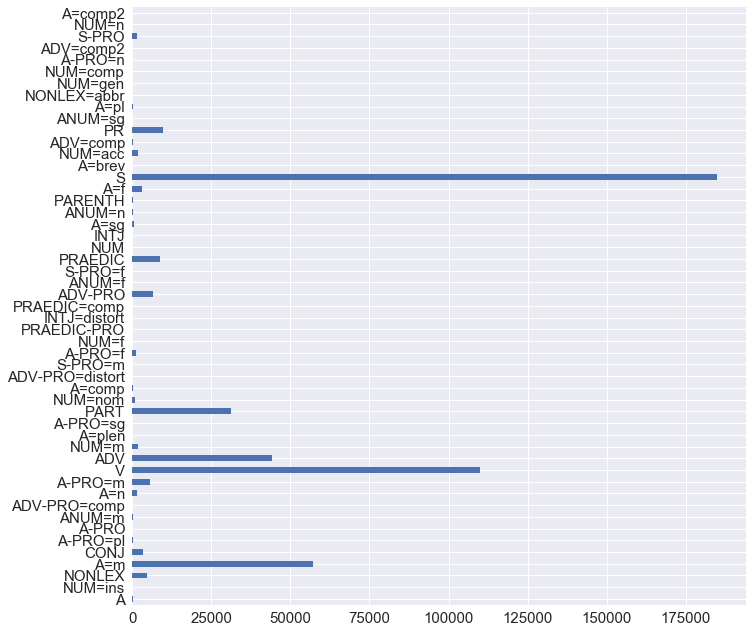

In [78]:
tag_frame.count().plot.barh(fontsize=15, figsize=(11, 11))

In [79]:
good_tags = ['A', 'A=m', 'ADV', 'V', 'PART', 'A=comp', 'A-PRO=f', 'PRAEDIC', 'INTJ', 'A=sg', 'A=f', 'S', 'ADV=comp', 'S-PR']
good_vocab = list(set(chain.from_iterable([get_tokens_by_tag(tag) for tag in good_tags])))
good_vocab[:5]

['переезжать', 'обменивать', 'наверно', 'скребок', 'строго']

In [80]:
def cut_by_good_vocab(tokenlist):
    return [t for t in tokenlist if t in good_vocab]
pos_cleaned_dataset = apply_to_dataset(only_alpha_dataset, cut_by_good_vocab)

Symbols: 423955 29202 4039


In [118]:
dataset_df = pd.concat([df['reting'], pos_cleaned_dataset[0], pos_cleaned_dataset[1], pos_cleaned_dataset[2]], axis=1)
dataset_df.head()

,reting,comment,commentPositive,commentNegative
0,2.0,"[год, работать, устать, лампочка, гореть, боль...",NaN,NaN
1,2.0,"[месяц, истечение, гарантийный, срок, машинка,...",NaN,NaN
2,4.0,"[пользоваться, неделя, нарекание, ни, какой, н...",NaN,NaN
3,5.0,"[ребята, системный, блок, подойти, игра, го, с...",NaN,NaN
4,5.0,"[считать, замечательный, телефон, приятно, дер...",NaN,NaN


In [112]:
len(dataset_df)

15587

In [119]:
def check_empty_texts(series):
    """Get unprocessed text for '[]' in Series"""
    empty_texts_indexes = series[series.astype(str) == '[]'].index
    return empty_texts_indexes
def remove_empty_texts(df):
    empty_indexes = check_empty_texts(dataset_df['comment'])
    df = df.drop(empty_indexes)
    return df

In [121]:
final_dataset = remove_empty_texts(dataset_df)
print(len(dataset_df), len(final_dataset))
final_dataset.head()

15587 15553


,reting,comment,commentPositive,commentNegative
0,2.0,"[год, работать, устать, лампочка, гореть, боль...",NaN,NaN
1,2.0,"[месяц, истечение, гарантийный, срок, машинка,...",NaN,NaN
2,4.0,"[пользоваться, неделя, нарекание, ни, какой, н...",NaN,NaN
3,5.0,"[ребята, системный, блок, подойти, игра, го, с...",NaN,NaN
4,5.0,"[считать, замечательный, телефон, приятно, дер...",NaN,NaN


In [122]:
def join_tokens(tokenlist):
    try:
        return ' '.join(tokenlist)
    except TypeError:
        return np.nan

In [130]:
final_dataset['comment_joined'] = [join_tokens(tokenlist) for tokenlist in final_dataset['comment']]
final_dataset['commentPositive_joined'] = [join_tokens(tokenlist)  for tokenlist in final_dataset['commentPositive'] ]
final_dataset['commentNegative_joined'] = [join_tokens(tokenlist)  for tokenlist in final_dataset['commentNegative']]
final_dataset.head()

,reting,comment,commentPositive,commentNegative,comment_joined,commentPositive_joined,BoW-unigrams,BoW-uni+bi,commentNegative_joined
0,2,"[год, работать, устать, лампочка, гореть, боль...",NaN,NaN,год работать устать лампочка гореть большой,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
1,2,"[месяц, истечение, гарантийный, срок, машинка,...",NaN,NaN,месяц истечение гарантийный срок машинка навер...,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
2,4,"[пользоваться, неделя, нарекание, ни, какой, н...",NaN,NaN,пользоваться неделя нарекание ни какой не поло...,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
3,5,"[ребята, системный, блок, подойти, игра, го, с...",NaN,NaN,ребята системный блок подойти игра го средний,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
4,5,"[считать, замечательный, телефон, приятно, дер...",NaN,NaN,считать замечательный телефон приятно держать ...,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN


In [131]:
vectorizer_u  = CountVectorizer(ngram_range=(1, 1))
# vectorizer_b  = CountVectorizer(ngram_range=(2, 2))
vectorizer_ub = CountVectorizer(ngram_range=(1, 2))

In [132]:
# Dataset
final_dataset['BoW-unigrams'] =  vectorizer_u.fit_transform(final_dataset['comment_joined'])
# counts_b  = vectorizer_b.fit_transform(refined_df['comment'])
final_dataset['BoW-uni+bi'] = vectorizer_ub.fit_transform(final_dataset['comment_joined'])
final_dataset.head(3)

,reting,comment,commentPositive,commentNegative,comment_joined,commentPositive_joined,BoW-unigrams,BoW-uni+bi,commentNegative_joined
0,2,"[год, работать, устать, лампочка, гореть, боль...",NaN,NaN,год работать устать лампочка гореть большой,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
1,2,"[месяц, истечение, гарантийный, срок, машинка,...",NaN,NaN,месяц истечение гарантийный срок машинка навер...,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN
2,4,"[пользоваться, неделя, нарекание, ни, какой, н...",NaN,NaN,пользоваться неделя нарекание ни какой не поло...,NaN,"(0, 323)\t1\n (0, 965)\t1\n (0, 2191)\t1\n...","(0, 35286)\t1\n (0, 84097)\t1\n (0, 227357...",NaN


# Model training

In [133]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# 1st layer model (binary 5/not5 prediction)

In [158]:
final_dataset['binary_reting'] = final_dataset['reting'].apply(lambda x: 0 if x==5 else 1)
# cut_df['reting'] = final_dataset['reting'].apply(round)
# cut_df = cut_df[cut_df.reting != 5]

In [155]:
cut_counts_ub = vectorizer_ub.transform(cut_df['comment_joined'])

In [159]:
rf_gini = RandomForestClassifier(n_estimators = 500, max_depth=50,class_weight='balanced', n_jobs=4, criterion='gini')

In [160]:
rf_gini.fit(cut_counts_ub, final_dataset['binary_reting'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [162]:
rf_gini.predict(cut_counts_ub)[:5]

array([1, 1, 1, 0, 0], dtype=int64)

# 2nd layer

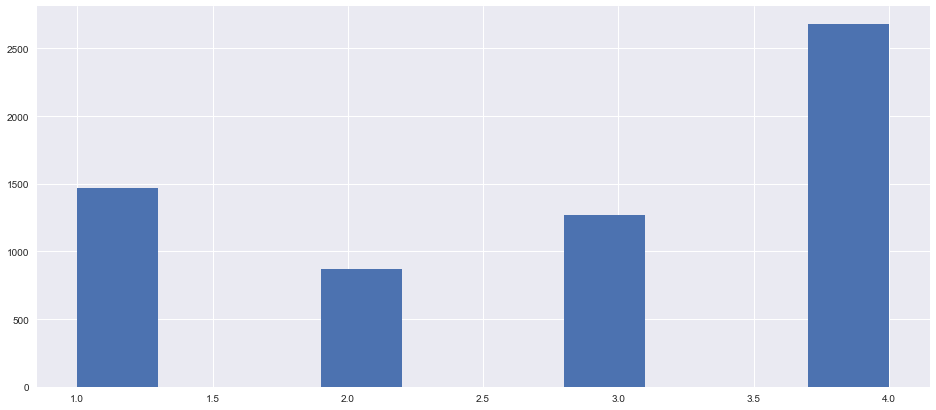

In [165]:
cut_df = final_dataset[final_dataset.reting != 5]
cut_df['reting'].hist()

In [166]:
four_class_counts_ub = vectorizer_ub.transform(cut_df['comment_joined'])
cut_rf_gini_ub = RandomForestClassifier(n_estimators = 500,
                                              max_depth=50,
                                              class_weight='balanced',
                                              n_jobs=4,
                                              criterion='gini')

In [167]:
cut_rf_gini_ub.fit(four_class_counts_ub, cut_df['reting'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [168]:
cut_rf_gini_ub.predict(four_class_counts_ub)[:5]

array([1, 2, 4, 1, 2], dtype=int64)

In [193]:
def preprocessing_line(comment_string):
    normalized = comment_string.lower().strip().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    padded =  pp.pad_punctuation(normalized)
    tokenized = nltk.word_tokenize(padded) # counting tokens now
    no_punct = pp.remove_punct(tokenized)
    no_stopwords = pp.remove_stopwords(no_punct)
    # print(no_stopwords)
    cut_by_vocab = [t for t in no_stopwords if t in alpha_tokens]
    return cut_by_vocab

In [194]:
preprocessing_line('привет как дела все очень хорошо')

['привет', 'очень', 'хорошо']

In [195]:
def predict(commentary):
    preprocessed = preprocessing_line(commentary)
    comment_string = join_tokens(preprocessed)
    # print(comment_string)
    bow = vectorizer_ub.transform([comment_string,])
    binary_prediction = rf_gini.predict(bow)
    if binary_prediction == 0:
        return 5
    else:
        return cut_rf_gini_ub.predict(bow)

In [196]:
predict('привет как дела все очень хорошо')

5

In [199]:
predictions = df['comment'].sample(10).map(predict)
predictions

9877       5
10072    [1]
307      [1]
3798     [1]
8654       5
4610     [1]
11462      5
3038       5
2115       5
3279       5
Name: comment, dtype: object

In [150]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
results = []
for n_estimators in [10, 50, 100, 200, 500]:
    for max_depth in [5, 10, 20, 50]:
        cut_rf_gini_ub = RandomForestClassifier(n_estimators = n_estimators,
                                              max_depth=max_depth,
                                              class_weight='balanced',
                                              n_jobs=4,
                                              criterion='gini')
        
        cv_u  = cross_val_score(predictor,  cut_counts_ub,  final_dataset['reting'], cv=kfold)
        print("cross validation svm+unigrams:\n{}\nn_estimators:{}\nmax_depth:{}\n".format(cv_u,
                                                                                           n_estimators,
                                                                                           max_depth))
        results.append(np.mean(cv_u))

cross validation svm+unigrams:
[ 0.21947927  0.28260031  0.29436728]
n_estimators:10
max_depth:5

cross validation svm+unigrams:
[ 0.24088717  0.3435571   0.28761574]
n_estimators:10
max_depth:10

cross validation svm+unigrams:
[ 0.41620058  0.36130401  0.51890432]
n_estimators:10
max_depth:20

cross validation svm+unigrams:
[ 0.48216008  0.47202932  0.54552469]
n_estimators:10
max_depth:50

cross validation svm+unigrams:
[ 0.40578592  0.39390432  0.38097994]
n_estimators:50
max_depth:5

cross validation svm+unigrams:
[ 0.50298939  0.49594907  0.46739969]
n_estimators:50
max_depth:10

cross validation svm+unigrams:
[ 0.55621986  0.56462191  0.55497685]
n_estimators:50
max_depth:20

cross validation svm+unigrams:
[ 0.61099325  0.61072531  0.63271605]
n_estimators:50
max_depth:50

cross validation svm+unigrams:
[ 0.49681774  0.47588735  0.47588735]
n_estimators:100
max_depth:5

cross validation svm+unigrams:
[ 0.55564127  0.5476466   0.54513889]
n_estimators:100
max_depth:10

cross valid

In [151]:
results

[0.26548228656975842,
 0.29068667134937359,
 0.43213630397514197,
 0.49990469649709707,
 0.39355672672833553,
 0.48877938597013387,
 0.55860621014242573,
 0.61814486926120382,
 0.48286414494962121,
 0.54947558890992132,
 0.58123824362774867,
 0.61801633044434123,
 0.5238870758281049,
 0.57178795572064078,
 0.59467668240135563,
 0.62721025998944402,
 0.55609844448809687,
 0.58586853052291554,
 0.60875800127782342,
 0.63499057257997304]

In [153]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

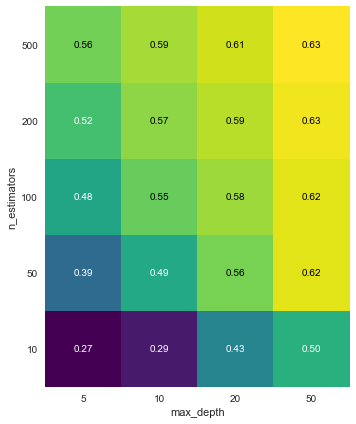

In [154]:
scores = np.array(results).reshape(5, 4)
param_grid = {'n_estimators': [10, 50, 100, 200, 500],
              'max_depth': [5, 10, 20, 50]}
heatmap(scores, ylabel='n_estimators', yticklabels=param_grid['n_estimators'],
xlabel='max_depth', xticklabels=param_grid['max_depth'], cmap="viridis")

In [ ]:
cv_ub = cross_val_score(cut_rf_gini_ub, cut_counts_ub, cut_df['reting'], cv=kfold)